In [1]:
# Dataset: Amazon Books Reviews
# Author: Mohamed Bekheet
# Source: Mohamed Bekheet. (2022). Amazon Books Reviews [Data set]. Kaggle. https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
# URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
# This dataset contains 2 files
# The first file** reviews** file contain feedback about 3M user on 212404 unique books the data set is 
# part of the Amazon review Dataset it contains product reviews and metadata from Amazon, including 
# 142.8 million reviews spanning May 1996 - July 2014.
# Reviews Dataset Data Dictionary:
# -id:                  The Id of Book
# -Title:   	        Book Title
# -Price:               The price of Book
# -User_id:             Id of the user who rates the book
# -profileName:         Name of the user who rates the book
# -review/helpfulness:  helpfulness rating of the review, e.g. 2/3
# -review/score:        rating from 0 to 5 for the book
# -review/time:         time of given the review
# -review/summary:      the summary of a text review
# -review/text:         the full text of a review

# The second file Books Details file contains details information about 212404 unique books it file is built by using
# google books API to get details information about books it rated in the first file
# and this file contains

# Book Details Dataset Data Dictionary:
# Title:	        Book Title
# Descripe:	        Decription of book
# authors:	        Name of book authors
# image:	        Url for book cover
# previewLink:	    Link to access this book on google Books
# publisher:	    Name of the publisheer
# publishedDate:	The date of publish
# infoLink:	        Link to get more information about the book on google books
# categories:	    Genres of books
# ratingsCount:	    Averaging rating for book

# Both Datasets are linked through the unique tittle of the book.

In [2]:
# Step 0. Load libraries and custom modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
from dateutil.parser import parse
from datetime import datetime
# ------------  PREPROCESING -------------
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#-------------- TRANSFORMERS --------------
import transformers
from transformers.pipelines import PIPELINE_REGISTRY
from transformers import pipeline
import evaluate
from evaluate import load
from transformers import Conversation
transformers.logging.set_verbosity_error()

/home/arnaldochm/Documents/BootCamp_DataScience/Final_Project/final_project_nlp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-29 21:16:14.802723: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-29 21:16:14.806818: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 21:16:14.850325: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 21:16:14.851313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimize

In [3]:
#Loading the Datasets
df_rating_raw = pd.read_csv('../data/raw/Books_rating.csv')

df_rating_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


In [4]:
df_rating_raw[df_rating_raw['Title'] == 'West Side story']

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
1814312,B000711OZC,West Side story,NaN,A3FV7U97W17PK,"M. Chaerani ""music sheet collector""",26/26,5.0,1145491200,Great transcription of the full score,If you're looking for a faithful translation f...
1814313,B000711OZC,West Side story,NaN,A14ES1GLFF6RZ9,"The Pianoman ""Producer/Arranger""",6/7,5.0,1189987200,West Side Vocal Score,If you want to play/arrange/orchestrate or sim...
1814314,B000711OZC,West Side story,NaN,APYTEBHJXFT18,Teen,4/5,4.0,1167177600,For the intermediate,The book is medium-it isn't an easy book you o...
1814315,B000711OZC,West Side story,NaN,A3H9EZYOVG81TW,Broadway Fan,1/1,5.0,1332374400,West Side Story,This book is perfect. We are rehearsing West S...
1814316,B000711OZC,West Side story,NaN,A1IWMVQGALYNVK,C. Morgan,3/4,5.0,1199145600,High Quality Printing,The piano and vocals are clearly printed which...
1814317,B000711OZC,West Side story,NaN,AZUS7ZIZWEJ0B,"Rebecca L. Gosselin ""Capegirl78""",0/0,5.0,1355702400,Fab!,this was perfect - I wanted to real versions o...
1814318,B000711OZC,West Side story,NaN,A1F2FPNK5VBJZ4,"W. Smith ""Future Tony Winner""",0/0,5.0,1264636800,A Composer/Orchestrator's Best Friend,My original intention was to buy this and use ...
1814319,B000711OZC,West Side story,NaN,A2DGD1PGXR5BZM,Olivertrst,0/1,3.0,1319241600,Disappointed -- Bent in shipping,I was disappointed when I received this book i...
1814320,B000711OZC,West Side story,NaN,A1GURUV4HPAWFU,Krista Cronin,2/9,5.0,955411200,West Side Story is Fabulous,"The music from West Side Story is captivating,..."


In [5]:
df_rating_raw.sample(10)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
2307396,0062586408,Screaming Life: A Chronicle of the Seattle Mus...,NaN,A2A46BUQRGSAB0,Sliver,2/2,5.0,1124755200,This is quintessential.,I love this book. If you can get a copy that c...
1362344,B0007379RC,The 7 habits of highly effective people: Wisdo...,NaN,A1JA4BR6KWA12E,michael.lacroix,0/0,5.0,1280102400,Wow,Not really sure this book even needs a review....
2151101,0300087659,The Other Boston Busing Story: What`s Won and ...,17.0,A317CUPDD6NKJN,shel99,7/9,5.0,993600000,Important insights,The Metropolitan Council for Educational Oppor...
2792147,B0006IU3ZS,Unfit for Command: Swift Boat Veterans Speak O...,NaN,AAP7PPBU72QFM,"D. C. Carrad ""augustabookman""",3/5,5.0,1092700800,The ring of truth,"Whatever your politics, it is hard to deny the..."
1504438,1932429239,Think and Grow Rich: The 21st-Century Edition:...,NaN,AP9A4M08AI9JZ,Nancy E. Lozano,0/1,5.0,1234137600,BEST ADVICE YOU CAN GET,I REALLY AGREED WITH EVERY CHAPTER IN THIS BOO...
270729,158479335X,Cook 1.0: A Fresh Approach to the Vegetarian K...,NaN,A38BIO5Q04IFP,Rafhael E. Cedeno,2/2,5.0,1168128000,Practical And Healthy,This book strikes a perfect balance between be...
385239,B000GR94JU,The Cat Who Went into the Closet,NaN,A2MSWQW6L9X18O,smartnurse123,0/0,4.0,1153785600,The Cat Who Went into the Closet,Another enjoyable book in the Cat Who series.....
1001970,B000J33RXK,Slaughterhouse-Five,NaN,A2A69NG7SMV8K1,"""enzion""",5/7,4.0,1042848000,another vonnegut masterpiece,Vonnegut once again introduces an audience to ...
2494030,0141181230,Siddhartha: An Indian Tale (Penguin Twentieth-...,8.0,A2ALDN6FAT15R,Marcia,0/22,1.0,1284163200,Book Not Received,"I would love to provide a review, but a month ..."
1249712,B000CNLIHE,Antoine de Saint-Exupery's: The Little Prince,NaN,A23NCES4K8E3SV,Leslie,0/1,4.0,1098576000,A Story for Every Age,The Little Prince by Antoine de Saint-Exupery ...


In [6]:
#Load Books Data Dataset
df_data_raw = pd.read_csv('../data/raw/books_data.csv')

df_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


In [7]:
df_data_raw.sample(10)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
168980,Coming of Age in Mississippi,The unforgettable memoir of a woman at the fro...,['Anne Moody'],http://books.google.com/books/content?id=bWwPI...,http://books.google.com/books?id=bWwPIHNdEZoC&...,Dell,2011-09-07,https://play.google.com/store/books/details?id...,['Biography & Autobiography'],20.0
142315,Dictionary of Word Roots and Combining Forms,One of the outstanding problems of the biologi...,['Donald Borror'],http://books.google.com/books/content?id=LVTls...,http://books.google.com/books?id=LVTlswEACAAJ&...,McGraw-Hill Education,1960-09-01,http://books.google.com/books?id=LVTlswEACAAJ&...,['Reference'],2.0
150714,Night coach to Paris,During the Great Terror following the French R...,['Rita Ritchie'],NaN,http://books.google.com/books?id=WWzBYgEACAAJ&...,NaN,1970,http://books.google.com/books?id=WWzBYgEACAAJ&...,['Cousins'],NaN
15233,Doctrine and Covenants Commentary,NaN,"['Hyrum M. Smith', 'Janne M. Sjodahl']",NaN,http://books.google.nl/books?id=vn_qPQAACAAJ&d...,Shadow Mountain,1978,http://books.google.nl/books?id=vn_qPQAACAAJ&d...,['Doctrine and Covenants'],NaN
70295,Smoke from This Altar,"Smoke From This Altar, a book that has become ...","[""Louis L'Amour""]",http://books.google.com/books/content?id=P64JP...,http://books.google.com/books?id=P64JPGFhgaEC&...,Bantam,2009-06-03,https://play.google.com/store/books/details?id...,['Poetry'],3.0
207680,A Lily Among Thorns: an allegory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205132,Sharing Nature With Children,When Joseph Cornell's classic book reached its...,['Joseph Bharat Cornell'],http://books.google.com/books/content?id=mUo9O...,http://books.google.com/books?id=mUo9OAAACAAJ&...,Dawn Publications (CA),1998-01-01,http://books.google.com/books?id=mUo9OAAACAAJ&...,['Family & Relationships'],3.0
174830,The Perpetrators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24358,Love (Buddhism For You series),A renowned Zen master and Nobel Peace Prize no...,['Thich Nhat Hanh'],http://books.google.com/books/content?id=naww1...,http://books.google.com/books?id=naww1Kyl1-oC&...,Shambhala Publications,2011-10-11,http://books.google.com/books?id=naww1Kyl1-oC&...,['Religion'],7.0
189393,Ultimate Questions,We human beings had no say in existing—we just...,['Bryan Magee'],http://books.google.com/books/content?id=p3KYD...,http://books.google.com/books?id=p3KYDwAAQBAJ&...,Princeton University Press,2017-09-26,http://books.google.com/books?id=p3KYDwAAQBAJ&...,['Philosophy'],1.0


In [8]:
#Revisar Valores Nulos
df_rating_raw.isna().sum()

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64

In [9]:
df_data_raw.isna().sum()

Title                 1
description       68442
authors           31413
image             52075
previewLink       23836
publisher         75886
publishedDate     25305
infoLink          23836
categories        41199
ratingsCount     162652
dtype: int64

In [10]:
#Innecesary Columns are removed
# df_rating: 
#   - Price: Almost 84% of the entries are null. 
#   - profileName: User_id provides same information.
#   - Id: Innecesary column.
#   - review/summary: Unncesary column for current analysis. Many summaries used are the same Book Title.  
# df_data:
#   - image, previewLink, infoLink: Not useful information.
#   - ratingsCount: Information from Google API. Not useful for the analysis.
#   - description: Non necesary information for Analysis

df_rating_processed = df_rating_raw.drop(['Id','profileName','Price','review/summary'], axis=1).copy()
df_data_processed = df_data_raw.drop(['image','previewLink','infoLink','ratingsCount','description'], axis=1).copy()

In [11]:
df_rating_processed.sample(10)

,Title,User_id,review/helpfulness,review/score,review/time,review/text
2833090,"Little women: Or Meg, Jo, Beth, and Amy",A2NPAPATNL3ZFL,0/1,1.0,1265241600,Borders Classics is a Borders imprint that mak...
1869225,Atlas Shrugged,A1G9GUAPHXXAWO,9/13,5.0,1235692800,She had a great insight into the dangers of ov...
559023,A Bell For Adano,A3H4OJXYRCVGNN,0/0,4.0,1340841600,This Pulitzer Prize-winning tale recounts the ...
942774,The Martian Chronicles (Time Reading Program),A2O6AIFJGSN07J,1/1,4.0,993686400,"At the beginning, it was very confusing, becau..."
2157724,Found Treasure,A3KBUACOFXYQE,12/12,5.0,1061251200,Euphemia Martin hates her name and wishes she ...
841612,Lord of the flies,NaN,0/0,5.0,942796800,I read this book in my 10th grade reading clas...
1786483,A Connecticut Yankee in King Arthur's Court,A19YNG73ZS44PU,0/0,5.0,1354233600,I enjoy Mark Twain. He was one of America's be...
1059656,Complete Guide to Building Log Homes,A6AX2CA3AX62H,22/24,1.0,1026950400,"Do not recommend buying, black and white old, ..."
2772468,They Speak With Other Tongues,AQJYY9KTEN7M0,0/0,5.0,1361577600,I wasn't born when all of this was going on - ...
23631,Getting Rid Of Bradley (Harlequin Temptation #...,A248VHGOE5WL6B,4/4,5.0,1055808000,On the day the divorce from her womanizing hus...


In [12]:
df_rating_processed = df_rating_processed.rename(columns={'Title':'title', 
                                                        'User_id':'user_id',
                                                        'review/helpfulness': 'helpfulness',
                                                        'review/score': 'review',
                                                        'review/time': 'review_time',
                                                        'review/text': 'text'
                                                        })
df_data_processed = df_data_processed.rename(columns={'Title':'title', 
                                                        'publishedDate':'published_date'
                                                        })

In [13]:
df_rating_processed.isna().sum()

title             208
user_id        561787
helpfulness         0
review              0
review_time         0
text                8
dtype: int64

In [14]:
df_data_processed.isna().sum()

title                 1
authors           31413
publisher         75886
published_date    25305
categories        41199
dtype: int64

In [16]:
#CLEAN THE DATASETS

In [15]:
#As both datasets are going to be merged by Title, Rows with Null Title are removed.
df_rating_processed = df_rating_processed.dropna(subset=['title', 'text'], how='any')

df_data_processed = df_data_processed.dropna(subset=['title'])

#Drop rows where everything except title is null
df_data_processed = df_data_processed.dropna(subset=['authors', 'publisher', 'published_date', 'categories'], how='all')

In [16]:
df_data_processed.sample(5)

,title,authors,publisher,published_date,categories
79801,Rough Guide First-time Europe : Special (3rd E...,['Darren (Norm) Longley'],Rough Guides UK,2010-04-01,['Travel']
84983,Conflict Resolution: Its Language and Processes,['John Wear Burton'],Scarecrow Press,1996,['Business & Economics']
93842,"Martin Van Buren, (American statesmen)",['John Torrey Morse'],NaN,1899,"['Statesmen, American']"
123894,Dear Boy,['Carrie Hughes'],University of Georgia Press,2013-11-15,['Literary Collections']
9019,Painter 6 f/x and Design,['Sherry London'],Coriolis Group,2000,['Computers']


In [17]:
# Found 143 published_date entries with the format YYYY*
# Found 76 published_date entries with the format YYY?
# Found 52 published_date entries with the format YY??

def convert_to_year(date_in):    
    try:    
        patern_1 = r'\d\d\d\?'
        patern_2 = r'\d\d\?\?'

        #Some dates only contain the Year with the format YYYY*. For those cases, the symbol * is removed.
        date = date_in.replace('*', '')

        #Other cases contains an ? symbol instead of a number on the Year. YYY? or YY??
        #For this specific case, the rounded mean from 0 to 9 is used: 5
        if re.match(patern_1, date):
            date = date.replace('?', '5')

        if re.match(patern_2, date):
            return None

        date = parse(date)
        
        return date.strftime("%Y")
    except:        
        return None

In [18]:
#Use only the year for published_date
df_data_processed['published_year'] = df_data_processed['published_date'].apply(lambda x: convert_to_year(x) if pd.notna(x) else x)

df_data_processed['published_year'] = df_data_processed['published_year'].fillna('0')

df_data_processed['published_year'] = df_data_processed['published_year'].astype('int32')

#Drop published_date column 
df_data_processed = df_data_processed.drop(['published_date'], axis=1)

In [19]:
mean_published_year = int(df_data_processed['published_year'].mean())
mean_published_year

1981

In [20]:
df_data_processed['published_year'] = df_data_processed['published_year'].apply(lambda x: mean_published_year if x==0 else x)
df_data_processed.sample(10)

,title,authors,publisher,categories,published_year
33251,The Four Fundamental Concepts of Psychoanalysi...,['Jacques Lacan'],W. W. Norton & Company,['Psychology'],1998
187046,Star Trek 6,['J.M. Dillard'],Simon and Schuster,['Fiction'],2002
188872,Our solar system (SuDoc NAS 1.2:SO 4/10),"['Asif A. Siddiqi', 'United States. NASA Histo...",National Aeronautis & Space Administration,['Planets'],2018
20720,Israel: A Photobiography: The First Fifty Years,"['Micha Bar-Am', 'Thomas L. Friedman']",Simon & Schuster,['History'],1998
171568,The life and death of King John (Macmillan's E...,"['William Shakespeare', 'K... Deighton']",NaN,NaN,1953
249,"Run Wild, Run Free",NaN,NaN,NaN,2013
34358,"Vandas: Their Botany, History and Culture",['Martin R. Motes'],Timber Press (OR),['Gardening'],1997
18715,Guess Who's Coming to Dinner : Celebrating Int...,['Brenda Lane Richardson'],Council Oak Books,['Family & Relationships'],2000
25150,A heritage of stone,['Jim Garrison'],NaN,NaN,1970
146383,"Bab Ballads, The",['W. S. GILBERT'],NaN,NaN,1906


In [21]:
#Updating the Authors to a list.
df_data_processed['authors'] = df_data_processed['authors'].apply(lambda x: x.replace("[", "") if pd.notna(x) else None)
df_data_processed['authors'] = df_data_processed['authors'].apply(lambda x: x.replace("]", "") if pd.notna(x) else None)
df_data_processed['authors'] = df_data_processed['authors'].apply(lambda x: x.replace("'", "") if pd.notna(x) else None)
df_data_processed['authors'] = df_data_processed['authors'].apply(lambda x: [author for author in str(x).split(",")] if pd.notna(x) else None)

In [22]:
#Updating Categories to list
df_data_processed['categories'] = df_data_processed['categories'].apply(lambda x: x.replace("[", "") if pd.notna(x) else None)
df_data_processed['categories'] = df_data_processed['categories'].apply(lambda x: x.replace("]", "") if pd.notna(x) else None)
df_data_processed['categories'] = df_data_processed['categories'].apply(lambda x: x.replace("'", "") if pd.notna(x) else None)
df_data_processed['categories'] = df_data_processed['categories'].apply(lambda x: [category for category in str(x).split(",")] if pd.notna(x) else None)

In [23]:
df_data_processed.sample(10, random_state=20)

,title,authors,publisher,categories,published_year
134060,Galois theory;: Lectures delivered at the Univ...,[Emil Artin],Courier Corporation,[Mathematics],2012
2306,The Sunday Tertulia: A Novel,[Lori Marie Carlson],Harper Collins,[Fiction],2009
49270,Suddenly They're 13,[David and Claudia Arp],Zondervan,[Religion],2010
115253,BEYOND MONSTERS AND CLOWNS. THE COMBAT SS. : D...,[Karl H. Theile],University Press of Amer,[History],1997
120696,Virginians at home: Family life in the eightee...,[Edmund Sears Morgan],Colonial Williamsburg Foundation,[History],1952
194758,Food Choice and Obesity in Black America: Crea...,[Eric J. Bailey],Greenwood Publishing Group,[African Americans],2006
10043,Lake Geneva in Vintage Postcards (WI) (Postcar...,"[Carolyn Hope Smeltzer, Martha Kiefer Cucco]",Arcadia Publishing,[History],2005
16651,"Where Are You Going, Manyoni?",[Catherine Stock],Harpercollins Childrens Books,[Juvenile Fiction],1993
61146,Twenty One Days to a Trained Dog,"[Dick Maller, Jeffrey Feinman]",Simon and Schuster,[Pets],1979
55622,"The German campaigns in the Balkans (spring, 1...",[George E. Blau],NaN,"[World War, 1939-1945]",1986


In [24]:
df_rating_processed.sample(5)

,title,user_id,helpfulness,review,review_time,text
1374483,Victory in Singleness: A Strategy for Emotiona...,A1QD1SLFU60QXV,0/0,5.0,1038873600,This book was such a blessing to me.... It was...
1247639,Of Mice and Men,A20VXF9DYI0I6H,1/1,5.0,1176768000,I'm not a big fan of sentimental moments and h...
240420,Cat Nips: The Comprehensive Cookbook for the C...,A2S3VCL3C53P0P,1/2,1.0,1187222400,This author managed to get a grade-school type...
2538986,Inhumans Vol.1 (Marvel Heroes),AHDNFUAGC5Z4E,1/1,3.0,1135900800,"Hi. As the author of the material, I'd like to..."
1184650,EAST OF EDEN,A2QO08DN1DTEWD,0/0,5.0,1195430400,While this book is a little rough around the e...


In [25]:
# CLEANING DATA FOR REVIEWS DATASET
df_rating_processed['review_year'] = df_rating_processed['review_time'].apply(lambda x: datetime.utcfromtimestamp(x).year)

df_rating_processed = df_rating_processed.drop(['review_time'], axis=1)

In [31]:
df_rating_processed.sample(10)

,title,user_id,helpfulness,review,text,review_year
1221908,Magnetic current,A29ABIFTV10NLA,10/10,1.0,DO NOT BUY THIS BOOK IF YOU ARE LOOKING FOR A ...,2009
795395,Great Expectations,NaN,1/1,5.0,When I was assigned to present a novel for my ...,2004
1190872,The Euston and Crewe companion,A1R03NBCMFTWR1,1/1,5.0,"This edition is 50 pages, with 8 pages of phot...",2012
105311,There And Now,AOVY1Q6WI9MHA,0/2,5.0,"i love linda l. miller books, will buy more fo...",2012
2179044,ONE HUNDRED YEARS OF SOLITUDE,APWAW7T85Y6DU,9/9,5.0,"How many Aurelianos, Arcadios, Joses and Buend...",2000
1590836,I know this much is true,AS362CECD7FTA,7/7,5.0,It's not often that I choose to read a book ov...,2000
323744,Ella Enchanted,ALQPUQXMC1TT,0/0,5.0,"Ok, first of all...the people who make bad com...",2002
2195228,Remembering Walt: Favorite Memories of Walt Di...,NaN,14/14,5.0,To sum up...WOW! Instead of relying on probabl...,1999
1065236,The Catcher in the Rye,A2P9UOZ23BX037,0/1,4.0,I read this book some months ago but I really ...,1997
2523282,Of Human Bondage,A1QAJA358LUE8F,7/7,5.0,I first read this book when I was about 20 and...,2005


In [34]:
#Changing helpfulness to a porcentual value
def get_helpfulness_as_porcentual_value(x):
    if  x == '0/0':
        return 0
    elif x.split('/')[0] == '0':
        return 0
    else:
        dividend = int(x.split('/')[0])
        divisor = int(x.split('/')[1])
        return dividend/divisor

In [37]:
df_rating_processed['helpfulness'] = df_rating_processed['helpfulness'].apply(lambda x: get_helpfulness_as_porcentual_value(x))

In [40]:
df_rating_processed.sample(10)

,title,user_id,helpfulness,review,text,review_year
585995,Jane Eyre: Complete and Unabridged (Puffin Cla...,A3TAICDI6GAJ6P,0.000000,5.0,This is a classic that I had somehow never rea...,2012
2405950,Leading Up: Transformational Leadership for Fu...,A1XTPQVVNAO6O2,1.000000,5.0,"As a brand new fundraising professional, I am ...",2006
887592,Indian Nocturne (New Directions),A2UDGZUEYHULS5,1.000000,5.0,The first time I read this book was when I als...,2000
2420489,Beginning Active Server Pages 2.0,AFSC1VH8FYZ0I,0.000000,5.0,"This is a great book for learning ASP, in fact...",2001
2814732,Bronte Myth,A247MSHDK6A4WJ,1.000000,3.0,The Bronte myth consists of preconcieved ideas...,2007
1974856,GENERATION of SWINE. Gonzo Papers Vol. 2.,NaN,0.833333,4.0,Fear &amp; Loathing on the campaign trail is p...,2000
1989716,Atlas Shrugged,NaN,0.444444,2.0,I think it's a mistake to just dismiss Ryan's ...,1999
1498729,We've Got Spirit: The Life and Times of Americ...,NaN,0.666667,5.0,"A page-turner, 'Spirit' takes us into the worl...",1999
945822,"The fountainhead,",NaN,0.800000,5.0,This book is absolutely stunning. After being ...,1999
2981144,Azerbaijan: Ethnicity and the Struggle for Pow...,A3FICX2HW4BDZR,0.750000,4.0,This is an interesting book to read for those ...,2006


In [41]:
#Merge The Two Datasets.
df_all_data_processed = pd.merge(df_rating_processed, df_data_processed, on='title', how='inner')
df_all_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666314 entries, 0 to 2666313
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   title           object 
 1   user_id         object 
 2   helpfulness     float64
 3   review          float64
 4   text            object 
 5   review_year     int64  
 6   authors         object 
 7   publisher       object 
 8   categories      object 
 9   published_year  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 203.4+ MB


In [42]:
df_all_data_processed.sample(10)

,title,user_id,helpfulness,review,text,review_year,authors,publisher,categories,published_year
418384,Commentaries on the Laws of England,A2KGEAB10O7JJB,0.956522,5.0,Every American lawyer ought to read Blackstone...,2001,"[William Blackstone, Thomas McIntyre Cooley]",Lawbook Exchange Limited,[Law],2003
677957,The High Blood Pressure Solution: A Scientific...,A2QU7Z3EPIKU9D,0.964286,5.0,I have been on blood pressure medication for o...,2005,[Richard D. Moore],Healing Arts Press,[Health & Fitness],2001
952882,Shadow Rising (Turtleback School & Library Bin...,AM4LS1EBMPID6,1.000000,4.0,"I wanted to give this a 3 3/4 or something, bu...",2000,[Leigh Bardugo],Turtleback Books,None,2015
316276,The Father of Spin: Edward L. Bernays and The ...,AFPZJRN7DSZ6C,0.800000,5.0,I am a PR professional. I read a lot of books ...,2001,[Larry Tye],Picador,[Biography & Autobiography],2002
667717,A Death in the Family,NaN,0.857143,5.0,"Agee is clearly a master wordsmith, as demonst...",2000,[Tessa Wegert],Penguin,[Fiction],2020
1092108,PHILOSOPHICAL DICTIONARY (TWO VOLUMES),NaN,1.000000,5.0,"I'm not your typical philosophe reader, being ...",2002,[Voltaire],NaN,[Free thought],1766
565776,The Hobbit,A2IRD98NPWC9YG,1.000000,5.0,I read this book as a fan of the LOTR movies a...,2012,[J. R. R. Tolkien],Mariner Books,[Juvenile Fiction],2012
1406153,Sun Tzu For Success: How to Use the Art of War...,AMWSZ61FILX2J,0.600000,3.0,The basic premise of the book follows ancient ...,2003,"[Gerald A Michaelson, Steven W Michaelson, S...",Simon and Schuster,[Self-Help],2003
824881,"Whistling Season, a Novel",A2ZWOSXTV0UVO1,0.916667,5.0,"If you're looking for sex and violence, skip i...",2006,[Ivan Doig],Paw Prints,None,2009
1166468,Lady Chatterley's Lover,A112VKJPV224PX,0.636364,2.0,Why is this book so famous? Some say for its q...,2000,[David Herbert Lawrence],Hyweb Technology Co. Ltd.,[Foreign Language Study],2011


In [43]:
#APPLY PARETO PRINCIPLE:
# Pareto Principle, also known as the 80/20 rule, is used for reducing the dataset based on the most reviewed books 
# This is a good approach to focus on the most significant or popular books. The Pareto Principle suggests that 
# roughly 80% of the effects come from 20% of the causes. In this case, Pareto principle to identify
# and keep the most influential books and their associated reviews. 

In [44]:
# Group the reviews by book and count the number of reviews for each book
book_reviews_count = df_all_data_processed['title'].value_counts().reset_index()
book_reviews_count.columns = ['title', 'num_reviews']

In [45]:
book_reviews_count.sample(10)

,title,num_reviews
102060,Treading in the Past: Sandals of the Anasazi,2
42208,Ace of Hearts: Book One Of The House of Cards ...,9
118314,Challenging Chomsky: The Generative Garden Game,2
173782,"IT Service Vision Software: Macro Reference, R...",1
99102,It's My Turn!,3
117848,Creation vs. Evolution: What You Need to Know,2
90212,And They Call It Help: The Psychiatric Policin...,3
25573,Dancing Naked-- In Fuzzy Red Slippers,15
125724,Renaissance Architecture,2
163237,Axioms: the book of health and science of trut...,1


In [46]:
# Sort the DataFrame by the number of reviews in descending order
book_reviews_count.sort_values(by='num_reviews', ascending=False, inplace=True)

In [47]:
book_reviews_count.head(10)

,title,num_reviews
0,The Hobbit,22023
1,Pride and Prejudice,20371
2,Wuthering Heights,10780
3,The Giver,7644
4,Great Expectations,7421
5,Harry Potter and The Sorcerer's Stone,6796
6,Brave New World,6312
7,Mere Christianity,6053
8,The Picture of Dorian Gray,5883
9,Persuasion,5498


In [48]:
# Calculate the cumulative percentage of reviews
total_reviews = book_reviews_count['num_reviews'].sum()
book_reviews_count['cumulative_percentage'] = (book_reviews_count['num_reviews'].cumsum() / total_reviews) * 100
book_reviews_count.head(10)

,title,num_reviews,cumulative_percentage
0,The Hobbit,22023,0.825972
1,Pride and Prejudice,20371,1.589985
2,Wuthering Heights,10780,1.994289
3,The Giver,7644,2.280977
4,Great Expectations,7421,2.559301
5,Harry Potter and The Sorcerer's Stone,6796,2.814185
6,Brave New World,6312,3.050916
7,Mere Christianity,6053,3.277934
8,The Picture of Dorian Gray,5883,3.498575
9,Persuasion,5498,3.704777


In [49]:
pareto_threshold = 20
# Select the subset of books that make up the top Pareto_threshold% of reviews
selected_books = book_reviews_count[book_reviews_count['cumulative_percentage'] <= pareto_threshold]
selected_books.head(10)

,title,num_reviews,cumulative_percentage
0,The Hobbit,22023,0.825972
1,Pride and Prejudice,20371,1.589985
2,Wuthering Heights,10780,1.994289
3,The Giver,7644,2.280977
4,Great Expectations,7421,2.559301
5,Harry Potter and The Sorcerer's Stone,6796,2.814185
6,Brave New World,6312,3.050916
7,Mere Christianity,6053,3.277934
8,The Picture of Dorian Gray,5883,3.498575
9,Persuasion,5498,3.704777


In [50]:
df_all_data_filtered_processed = df_all_data_processed.merge(selected_books, on='title', how='inner')
df_all_data_filtered_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532868 entries, 0 to 532867
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   title                  532868 non-null  object 
 1   user_id                406985 non-null  object 
 2   helpfulness            532868 non-null  float64
 3   review                 532868 non-null  float64
 4   text                   532868 non-null  object 
 5   review_year            532868 non-null  int64  
 6   authors                526675 non-null  object 
 7   publisher              448830 non-null  object 
 8   categories             465707 non-null  object 
 9   published_year         532868 non-null  int64  
 10  num_reviews            532868 non-null  int64  
 11  cumulative_percentage  532868 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 48.8+ MB


In [ ]:
df_all_data_filtered_processed = df_all_data_filtered_processed.drop(['cumulative_percentage'], axis=1)

In [51]:
df_all_data_filtered_processed['review'].value_counts()

review
5.0    336553
4.0     95230
3.0     40291
1.0     35916
2.0     24878
Name: count, dtype: int64

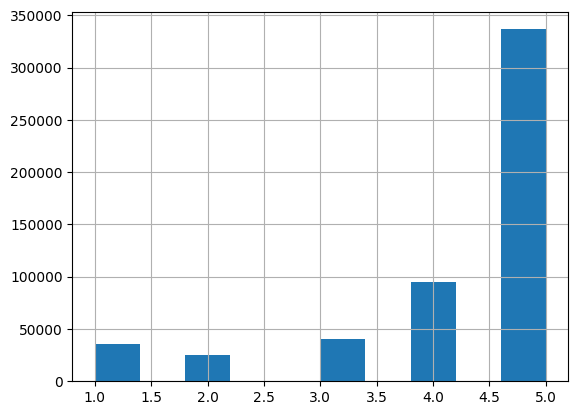

In [52]:
df_all_data_filtered_processed['review'].hist()
plt.show()
#Add axes.

In [53]:
df_all_data_filtered_processed.isna().sum()

title                         0
user_id                  125883
helpfulness                   0
review                        0
text                          0
review_year                   0
authors                    6193
publisher                 84038
categories                67161
published_year                0
num_reviews                   0
cumulative_percentage         0
dtype: int64

In [54]:
df_all_data_filtered_processed.sample(10)

,title,user_id,helpfulness,review,text,review_year,authors,publisher,categories,published_year,num_reviews,cumulative_percentage
18532,Night,NaN,0.750000,5.0,this book was amazing. It has been a long time...,2007,[Clement Moore],Applesauce Press,[Juvenile Fiction],2011,2874,7.631997
395148,The Autobiography of Benjamin Franklin,A8A3FXPCVZM3U,0.000000,5.0,Every thing was ok on the order. Shipped on ti...,2013,[Benjamin Franklin],Createspace Independent Publishing Platform,None,2018,1955,10.980815
56542,The Shelters Of Stone - The Earth's Children S...,A19JW51JRISMCF,0.888889,1.0,I was so disappointed in this book that were s...,2007,[Jean M. Auel],Bantam Books,[Fiction],2002,913,19.158284
369464,OF MICE AND MEN,A2V9S3MCHCXJGF,0.000000,4.0,Of Mice and Men was written by John Steinbeck....,2005,[John Steinbeck],Penguin,[Fiction],1994,1348,14.793081
142683,Hatchet,A2NRLRXT9LV0UN,0.000000,5.0,This is a really good book it will blow it min...,2013,[Gary Paulsen],Simon and Schuster,[Juvenile Fiction],2009,3076,6.852306
34552,Lord of the flies,NaN,0.000000,1.0,What a piece of crap! It was so comlicated tha...,1999,[William Golding],Penguin,[Fiction],2016,3119,6.620413
146861,"Guns, Germs, and Steel: The Fates of Human Soc...",A3KRXQUVZ1JCCC,0.166667,1.0,This poor pampered professor while struggling ...,2008,[Jared Diamond],W. W. Norton & Company,[History],2017,1379,14.590030
208501,Alice's Adventures in Wonderland,A12HZUBQMJ0D1R,0.000000,2.0,I really enjoyed this book just the book is no...,2013,[Lewis Carroll],The Floating Press,[Fiction],2009,3009,7.192064
13683,One Hundred Years of Solitude,NaN,0.000000,5.0,Mr. Marquez weaves an eloquently flowing tapes...,1996,[Gabriel García Márquez],Everyman's Library,[Fiction],1995,907,19.260335
446387,Love You Forever,A2JCNVXT7K29JB,0.000000,5.0,Robert Munsch books have been translated into ...,2010,[Robert N. Munsch],Firefly Books,[Juvenile Fiction],1986,1439,14.325845


In [55]:
df_all_data_filtered_processed = df_all_data_filtered_processed.drop_duplicates(subset=['title','user_id', 'review', 'text'])

In [56]:
df_all_data_filtered_processed = df_all_data_filtered_processed.reset_index()

In [57]:
df_all_data_filtered_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339620 entries, 0 to 339619
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  339620 non-null  int64  
 1   title                  339620 non-null  object 
 2   user_id                253152 non-null  object 
 3   helpfulness            339620 non-null  float64
 4   review                 339620 non-null  float64
 5   text                   339620 non-null  object 
 6   review_year            339620 non-null  int64  
 7   authors                334206 non-null  object 
 8   publisher              282177 non-null  object 
 9   categories             309345 non-null  object 
 10  published_year         339620 non-null  int64  
 11  num_reviews            339620 non-null  int64  
 12  cumulative_percentage  339620 non-null  float64
dtypes: float64(3), int64(4), object(6)
memory usage: 33.7+ MB


In [58]:
df_all_data_filtered_processed.to_csv('../data/processed/filtered_data_processed.csv')

In [59]:
#Recomendacion de Manu para procesamiento
df_all_data_filtered_processed['num_row'] = np.arange(len(df_all_data_filtered_processed))

df_reduced = df_all_data_filtered_processed[['num_row', 'text']].copy()

df_reduced.sample(10)

,num_row,text
329358,329358,"Whether you're an undergraduate student, an MB..."
152392,152392,If youre looking for a deliciously disgusting ...
259174,259174,This is such a special children's book about a...
241444,241444,Could've been 100 pages shorter. About halfway...
203513,203513,"I was concerned that it would be ""fluff"", more..."
93103,93103,"I now know how to wash silk by hand, adjust a ..."
73386,73386,Beautiful Deluxe Edition! Especially loved the...
99132,99132,I have wanted a complete hardcover box set of ...
86703,86703,"I loved it , it was just what i was looking fo..."
6995,6995,I read this book aged 15 for my GCSE English l...


In [60]:
df_reduced.to_csv('../data/processed/df_reduced.csv')